## Model Pipeline
**Data preprocessing**: Resize to 224x224, binarize, and apply n=2 morphological thinning (detect model); Resized to 224x224 with no filters (classify model)

**Model**: Tandem inference implementation of the detection and classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import pipeline_helpers as helper

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data
Dataset must have the following columns: 
- **waferMap**: defect data of wafer map where 0 = blank spot, 1 = normal die (passed the electrical test), and 2 = broken die (failed electrical test)
- **ID**: unique identification for each waferMap, separate from dataframe index

If labeled, dataset must have the following columns:
- **detectLabels**: for evaluating the detect model, where 0 = no defect, 1 = defect
- **classifyLabels**: for evaluating the classify model, where 0 = Loc, 1 = Edge-Loc, 2 = Center, 3 = Edge-Ring, 4 = Scratch, 5 = Random, 6 = Near-full, 7 = Donut, 8 = none

In [5]:
# specify variables

# specify data to load
path = 'processed_data/customer'
filename = 'MixedWM38-single'
labeled = True

# where to save results
result_path = 'results'
result_filename = 'yutandem-best-mixedwm38-single'

# which models to run
detect_model = 'yudetect-224-thin2'
classify_model = 'yuclassify-224'

In [6]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = f'{path}/{filename}.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.57 seconds
Dataset length: 8015


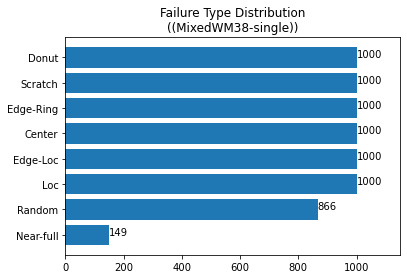

In [7]:
# IF LABELED
# show failure type distribution
if labeled:
    data_defects = data[data.detectLabels == 1]
    helper.defect_distribution(data_defects, note=f'({filename})')

### Data preprocessing

In [8]:
# resize to 224x224
start = time.time()

def resize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y
    
data['waferMap224'] = data.waferMap.apply(lambda x: resize(x))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.waferMap224[0].shape}')

Wall time: 17.45 seconds
Sanity checks:
Map shape: (224, 224)


In [9]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def preprocess(x):
    ret, thresh_img = cv2.threshold(x, 1, 1, cv2.THRESH_BINARY)
    thin_img = thin(thresh_img, 2)
    return thin_img
    
data['thinMap2'] = data.waferMap224.apply(lambda x: preprocess(x))
data['thinMap2'] = data.thinMap2.apply(lambda x: x.astype(np.uint8))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.thinMap2[0].shape}')

Wall time: 33.41 seconds
Sanity checks:
Map shape: (224, 224)


### Detect Model

##### Detect data set-up

In [10]:
# prepare inputs
start = time.time()

x_det = np.stack(data['thinMap2'])
x_det = tf.expand_dims(x_det, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_det.shape

Wall time: 1.29 seconds


TensorShape([8015, 224, 224, 1])

In [11]:
# IF LABELED
# prepare labels for evaluating results
if labeled:
    y_det = np.asarray(data['detectLabels']).astype(np.uint8)

##### Load and run detect model

In [12]:
# load saved detect model from S3
start = time.time()

detect = helper.s3_get_keras_model(detect_model)
detect.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [13]:
# generate predictions
start = time.time()

detect_pred = detect.predict(x_det)
det_labels = np.argmax(detect_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 4.53 seconds


Baseline accuracy: 12.48%
Detection Model Accuracy: 90.47%


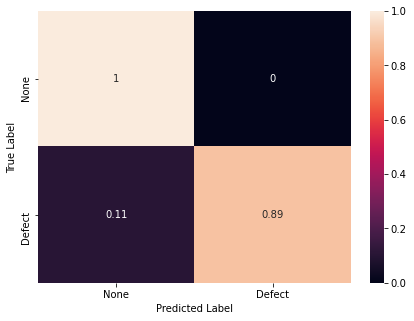

In [14]:
# IF LABELED
# evaluate detect model performance
if labeled:
    
    # calculate baseline accuracy
    nones = len(data[data.detectLabels == 0])
    total = len(data)
    print(f"Baseline accuracy: {nones/total*100:.2f}%")
    
    # manually compute detect model accuracy
    det_cm = confusion_matrix(y_det, det_labels)
    det_accuracy = (det_cm[0][0] + det_cm[1][1]) / len(y_det) * 100
    print(f'Detection Model Accuracy: {det_accuracy:.2f}%')
    
    # plot confusion matrix
    helper.plot_confusion_matrix(y_det, det_labels, mode='detect', normalize=True)

### Classify Model

##### Classify data set-up

In [15]:
# keep only subset of test data
# predicted by detect model as having defects
defect_indices = [i for i in range(len(det_labels)) if det_labels[i] == 1]
defect_ids = [data.ID[i] for i in defect_indices]
defect_df = data.loc[defect_indices].reset_index(drop=True)

# sanity check:
print("Sanity checks:")
print(f'{len(defect_indices)}, {len(defect_ids)}, {defect_df.shape}')

Sanity checks:
6251, 6251, (6251, 9)


In [16]:
# prepare inputs
start = time.time()

x_cls = np.stack(defect_df['waferMap224'])
x_cls = tf.expand_dims(x_cls, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_cls.shape

Wall time: 0.40 seconds


TensorShape([6251, 224, 224, 1])

In [17]:
# IF LABELED
# prepare labels for evaluating results
if labeled:
    y_cls = np.asarray(defect_df['classifyLabels']).astype(np.uint8)

##### Load and run classify model

In [18]:
# load saved classify model from S3
start = time.time()

classify = helper.s3_get_keras_model(classify_model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

In [19]:
# generate predictions
start = time.time()

classify_pred = classify.predict(x_cls)
cls_labels = np.argmax(classify_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 4.49 seconds


### Collect tandem model results
Saved predictions include 4 lists:
- IDs of defective wafers identified by detect model
- Output of detect model (softmax probabilities)
- Output of classify model (softmax probabilities)
- Labels predicted by tandem model

In [20]:
# generate full prediction
def tandem_prediction(x):
    if x in set(defect_ids):
        i = defect_ids.index(x)
        return cls_labels[i]
    else:
        return 8

data['tandemLabels'] = data.ID.apply(lambda x: tandem_prediction(x))
tandem_pred = data['tandemLabels'].tolist()
print(len(tandem_pred))

8015


In [21]:
# save predictions to local instance
predictions = [defect_ids, detect_pred, classify_pred, tandem_pred]
with open(f'{result_path}/{result_filename}.pkl', "wb") as f:
    pickle.dump(predictions, f)

Overall Model Accuracy: 68.37%


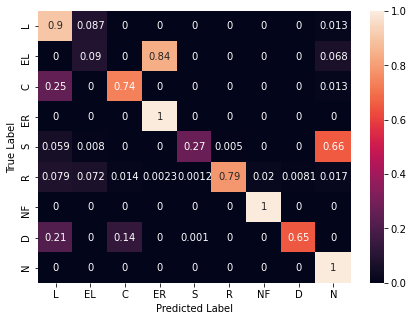

In [22]:
# IF LABELED
if labeled:
    y_test = data['classifyLabels'].tolist()
    
    # manually compute overall accuracy
    tandem_cm = confusion_matrix(y_test, tandem_pred)

    tandem_num = 0
    for i in range(9):
        tandem_num += tandem_cm[i][i]

    overall_accuracy = tandem_num / len(y_test) * 100
    print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, tandem_pred, mode='all', normalize=True)

### Error Analysis

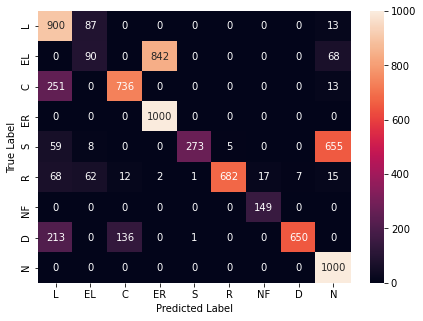

In [23]:
# IF LABELED
# plot confusion matrix counts
if labeled:
    helper.plot_confusion_matrix(y_test, tandem_pred, mode='all', normalize=False)

Scratch mislabled as None


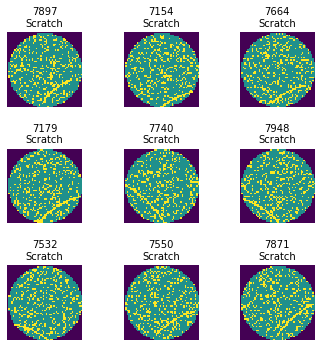

In [24]:
# IF LABELED
# plot S mislabeled as N
if labeled:
    print('Scratch mislabled as None')
    helper.visualize_misclassified(data, y_test, tandem_pred, true_label=4, pred_label=8, n=9, 
                            figsize=(5,5), col='waferMap', cmap='viridis')

Edge-Loc mislabled as Edge-Ring


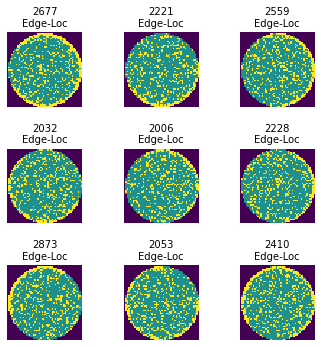

In [25]:
# IF LABELED
# plot EL mislabeled as ER
if labeled:
    print('Edge-Loc mislabled as Edge-Ring')
    helper.visualize_misclassified(data, y_test, tandem_pred, true_label=1, pred_label=3, n=9, 
                            figsize=(5,5), col='waferMap', cmap='viridis')

Donut mislabled as Center


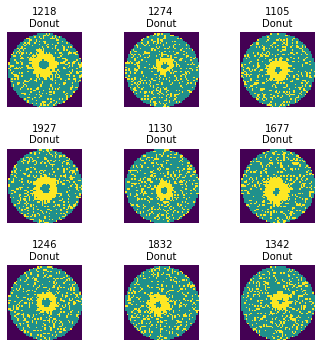

In [26]:
# IF LABELED
# plot D mislabeled as C
if labeled:
    print('Donut mislabled as Center')
    helper.visualize_misclassified(data, y_test, tandem_pred, true_label=7, pred_label=2, n=9, 
                            figsize=(5,5), col='waferMap', cmap='viridis')